**Warcraft Logs Parsing**

In [1]:
#imports 
import requests
import pprint
from datetime import datetime
import pytz
import time
import pandas as pd
import json
import os

In [2]:
GUILD_NAME = 'Antiquity' #can use another guild if you want
SERVER = 'Mankrik' #can do a different server
REGION = 'US' #can do a different region (e.g. EU, KR, etc)
START_DATE = '01-01-2020' #date to start report generation
CLASS = 'Priest' #different classes can be used, if DPS DPS graphs will show, if healing HPS/dispel/consume usage graphs will display
TYPE = 'Healing' #need to provide type to remove DPS classes, eg shadow priests
API_KEY = os.getenv('WOW_API_KEY')
USER_UPLOAD = 'torak12345'

In [52]:
#pretty printing json
pp = pprint.PrettyPrinter(indent=4)
#Roster
roster = {'Priest': ['Kazrik',
                    'Healthledger',
                    'Gamex',
                    'Berrynscream',
                    'Kelan',
                    'Sality',
                    'Avanya',
                    'Patterns',
                    'Ricc',
                    'IlililI']}

In [54]:
def convert_date_to_utc(date):
    date = datetime.strptime(date, "%d-%m-%Y")
    return int(time.mktime(date.timetuple()))*1000

In [55]:
#query for reports
get_reports = 'https://classic.warcraftlogs.com:443/v1/reports/guild/{guild_name}/{server}/{region}?start={start_date}&api_key={api_key}' \
                .format(guild_name = GUILD_NAME,
                       server = SERVER,
                       region = REGION,
                       start_date = convert_date_to_utc(START_DATE),
                       api_key = API_KEY)
print(get_reports)

https://classic.warcraftlogs.com:443/v1/reports/guild/Antiquity/Mankrik/US?start=1577854800000&api_key=0eca65db6830098d205bf7571580dd64


In [56]:
#get all reports from start date
reports = requests.get(get_reports)
assert reports.status_code == 200

In [121]:
#convert to datetimes 
df = pd.read_json(reports.text)
df['start'] = pd.to_datetime(df['start'], unit='ms')
df['end'] = pd.to_datetime(df['end'], unit='ms')

#add week of year
df['week_of_year'] = df['start'].dt.week

print(len(df))
df.head()

113


,id,title,owner,start,end,zone,week_of_year
0,yaAbMjv8tKXCQrfn,Team T Onyxia,torak12345,2020-04-03 02:53:20.926,2020-04-03 02:59:10.203,1001,14
1,9Cp3NZTkA41hyBJ2,Team T MC29,torak12345,2020-04-03 01:25:42.954,2020-04-03 02:46:05.435,1000,14
2,ADnR1G6c8KHg7tjT,Team T BWL29,torak12345,2020-04-02 23:51:44.960,2020-04-03 01:21:45.934,1002,14
3,ZxHW7GhcfM2XY4tj,Team M Onyxia,torak12345,2020-04-01 02:55:43.292,2020-04-01 03:06:45.839,1001,14
4,R1wq7z4T26KJcQkY,3/31 Ony,Sookies,2020-04-01 02:48:04.549,2020-04-01 03:01:46.821,1001,14


In [122]:
#filter for just torak
df = df[df['owner'].str.match(USER_UPLOAD)]
print(len(df))
df.head()

74


,id,title,owner,start,end,zone,week_of_year
0,yaAbMjv8tKXCQrfn,Team T Onyxia,torak12345,2020-04-03 02:53:20.926,2020-04-03 02:59:10.203,1001,14
1,9Cp3NZTkA41hyBJ2,Team T MC29,torak12345,2020-04-03 01:25:42.954,2020-04-03 02:46:05.435,1000,14
2,ADnR1G6c8KHg7tjT,Team T BWL29,torak12345,2020-04-02 23:51:44.960,2020-04-03 01:21:45.934,1002,14
3,ZxHW7GhcfM2XY4tj,Team M Onyxia,torak12345,2020-04-01 02:55:43.292,2020-04-01 03:06:45.839,1001,14
5,p8AFJzByZNGjw1hf,Team M MC29,torak12345,2020-04-01 01:32:05.680,2020-04-01 02:51:43.707,1000,14


**Zone 1000 = MC**

**Zone 1001 = Ony**

**Zone 1002 = BWL**

In [123]:
#Lets just focus on BWL for now
df = df[df['zone'] == 1002]
print(len(df))
df.head()

15


,id,title,owner,start,end,zone,week_of_year
2,ADnR1G6c8KHg7tjT,Team T BWL29,torak12345,2020-04-02 23:51:44.960,2020-04-03 01:21:45.934,1002,14
7,B6YkLMXvRzwVAxZ8,Team M BWL29,torak12345,2020-03-31 23:49:53.005,2020-04-01 01:24:16.764,1002,14
12,MWfPzkv7bCBm3qN1,Team T BWL28,torak12345,2020-03-26 23:56:43.294,2020-03-27 01:25:07.799,1002,13
18,f31HApYQK9qMNawX,Team M BWL28,torak12345,2020-03-24 23:49:02.361,2020-03-25 01:29:56.073,1002,13
21,B1ZatHyJKL8TbVWn,Team T BWL27,torak12345,2020-03-19 23:59:24.847,2020-03-20 01:16:29.480,1002,12


In [169]:
def get_fights_per_raid(row):
    get_fights = 'https://classic.warcraftlogs.com:443/v1/report/fights/{code}?api_key={api_key}' \
                    .format(code = row.id,
                           api_key = API_KEY)
    fights = requests.get(get_fights)
    assert fights.status_code == 200
    
    df = pd.DataFrame(fights.json()['fights'])
    df = df.dropna(subset=['size'])
    df['week_of_year'] = row.week_of_year
    df['title'] = row.title
    df['zone'] = row.zone
    df['raid_start'] = row.start
    df['raid_end'] = row.end
    df['id'] = row.id
    return df

In [170]:
fights = pd.DataFrame()
for i, row in enumerate(df.iterrows()):
    temp_df = get_fights_per_raid(row[1])
    fights = fights.append(temp_df)
    
fights = fights[fights.kill == True]
fights = fights.reset_index()
print(fights.head())

   index  boss  bossPercentage  difficulty  end_time  fightPercentage  \
0      1   610             0.0         3.0    660238              0.0   
1      3   611             0.0         3.0    966390              0.0   
2     11   612             0.0         3.0   1862639              0.0   
3     16   613             0.0         3.0   2545973              0.0   
4     25   614             0.0         3.0   3519970              0.0   

                 id  kill  lastPhaseForPercentageDisplay maps  \
0  ADnR1G6c8KHg7tjT  True                            0.0   []   
1  ADnR1G6c8KHg7tjT  True                            0.0   []   
2  ADnR1G6c8KHg7tjT  True                            0.0   []   
3  ADnR1G6c8KHg7tjT  True                            0.0   []   
4  ADnR1G6c8KHg7tjT  True                            0.0   []   

                      name  originalBoss  partial                raid_end  \
0    Razorgore the Untamed           NaN      2.0 2020-04-03 01:21:45.934   
1  Vaelastrasz t

In [205]:
def get_data_per_fight(row):
    if TYPE == 'Healing':
        get_data = 'https://classic.warcraftlogs.com:443/v1/report/tables/{type_of_data}/{code}?start={start}&end={end}&api_key={api_key}' \
                    .format(type_of_data = 'healing',
                            code = row.id,
                            start = row.start_time,
                            end = row.end_time,
                            api_key = API_KEY)
        data = requests.get(get_data)
        assert data.status_code == 200
        df = pd.DataFrame(data.json()['entries'])
        df = df[df['name'].isin(roster['Priest'])]
        df['fight_time'] = (row.end_time - row.start_time)/1000
        df['hps'] = df['total']/df['fight_time']
        df['week_of_year'] = row.week_of_year
        #print(df)
        return df
    else:
        return pd.DataFrame()
    

In [206]:
data = pd.DataFrame()
for i, row in enumerate(fights.iterrows()):
    temp_df = get_data_per_fight(row[1])
    data = data.append(temp_df)

data = data.reset_index()
print(data.head())

   index                                          abilities  activeTime  \
0      2  [{'name': 'Flash Heal', 'total': 5712, 'type':...       20292   
1      3  [{'name': 'Flash Heal', 'total': 1153, 'type':...       23880   
2      4  [{'name': 'Flash Heal', 'total': 3562, 'type':...       27953   
3     14       [{'name': 'Heal', 'total': 6089, 'type': 2}]       29164   
4      9  [{'name': 'Flash Heal', 'total': 13767, 'type'...       35663   

   activeTimeReduced                                    damageAbilities  \
0            13800.0  [{'name': 'Cleave', 'total': 5078, 'type': 1},...   
1            10868.0  [{'name': 'Melee', 'total': 695, 'type': 1}, {...   
2            25937.0  [{'name': 'Cleave', 'total': 2458, 'type': 1},...   
3            26719.0  [{'name': 'Melee', 'total': 3592, 'type': 1}, ...   
4            29990.0  [{'name': 'Flame Breath', 'total': 7630, 'type...   

   fight_time                                               gear      guid  \
0      31.417       

In [201]:
len(data)

504

In [220]:
data_by_week = data.groupby(['week_of_year', 'name']).agg({'hps': 'mean'})
data_by_week = data_by_week.reset_index()
data_by_week = data_by_week.pivot(index='week_of_year', columns='name', values='hps')

In [221]:
len(data_by_week)
print(data_by_week.head())

name              Avanya  Berrynscream       Gamex  Healthledger      Kazrik  \
week_of_year                                                                   
7             212.605188    246.696696         NaN    241.872769  325.758871   
8             171.810836    205.453112  246.749286    323.966859  318.461131   
9             253.592470    292.720388  237.513235    320.695487  307.061999   
10            219.483588    272.082001  161.849861    263.527091  343.781131   
11            184.438533    186.156654  258.961423    237.442376  252.192131   

name               Kelan    Patterns        Ricc      Sality  
week_of_year                                                  
7             228.464356         NaN         NaN         NaN  
8             248.100999         NaN         NaN  226.736293  
9             274.348365         NaN  206.014503  246.573800  
10            217.045770         NaN  185.672772  190.904511  
11            225.935906  229.438464  110.962125  229.314028 

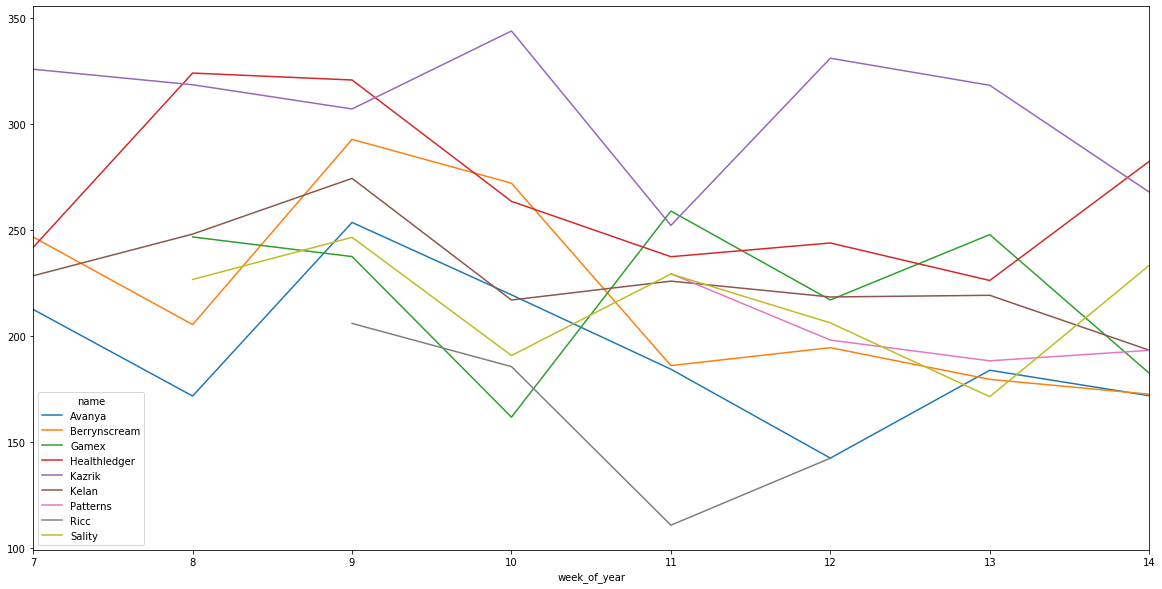

In [222]:
%matplotlib inline


data_by_week.plot(figsize = (20,10))

**Kaz and Health are cheaters with renew**